In [1]:
!git clone https://github.com/ayulockin/synthetic_datasets
%cd synthetic_datasets/MNIST/
%mkdir images
!unzip -q MNIST_Converted_Training.zip -d images/
!unzip -q MNIST_Converted_Testing.zip -d images/

Cloning into 'synthetic_datasets'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 42 (delta 1), reused 1 (delta 1), pack-reused 39
Receiving objects: 100% (42/42), 42.06 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/synthetic_datasets/MNIST


In [2]:
%cd ../..

/content


In [3]:
import pandas as pd
import os
s = 'synthetic_datasets'
m = 'MNIST'
i = 'images'
train_df = pd.read_csv(os.path.join(s,m , 'training_data.csv'), header=None)
test_df = pd.read_csv(os.path.join(s,m , 'test_data.csv'), header=None)
columns = ['path' , 'class_index' , 'xmin' , 'ymin' , 'xmax' , 'ymax']
train_df.columns = columns
test_df.columns = columns

In [4]:
train_df.head()

,path,class_index,xmin,ymin,xmax,ymax
0,converted_training1.png,4,0.49,0.15,0.77,0.43
1,converted_training2.png,1,0.64,0.26,0.92,0.54
2,converted_training3.png,0,0.42,0.39,0.70,0.67
3,converted_training4.png,7,0.58,0.10,0.86,0.38
4,converted_training5.png,8,0.21,0.23,0.49,0.51


In [5]:
test_df.head()

,path,class_index,xmin,ymin,xmax,ymax
0,converted_testing1.png,2,0.20,0.45,0.48,0.73
1,converted_testing2.png,0,0.02,0.03,0.30,0.31
2,converted_testing3.png,4,0.55,0.39,0.83,0.67
3,converted_testing4.png,8,0.38,0.42,0.66,0.70
4,converted_testing5.png,7,0.69,0.17,0.97,0.45


In [6]:
t1 ='MNIST_Converted_Training'
t2 ='MNIST_Converted_Testing'
train_df['path'] = train_df['path'].apply(lambda img_name : os.path.join(s , m , i ,t1 , img_name))
test_df['path'] = test_df['path'].apply(lambda img_name : os.path.join(s , m , i ,t2 , img_name))

In [7]:
train_df.head()

,path,class_index,xmin,ymin,xmax,ymax
0,synthetic_datasets/MNIST/images/MNIST_Converte...,4,0.49,0.15,0.77,0.43
1,synthetic_datasets/MNIST/images/MNIST_Converte...,1,0.64,0.26,0.92,0.54
2,synthetic_datasets/MNIST/images/MNIST_Converte...,0,0.42,0.39,0.70,0.67
3,synthetic_datasets/MNIST/images/MNIST_Converte...,7,0.58,0.10,0.86,0.38
4,synthetic_datasets/MNIST/images/MNIST_Converte...,8,0.21,0.23,0.49,0.51


In [9]:
import cv2
img = cv2.imread(train_df.iloc[0,0] )
img.shape

(100, 100, 3)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
def plot_img(img_path , x_min , y_min , x_max , y_max)  :
  img = cv2.imread(img_path)
  img = cv2.rectangle(img , (int(x_min*100) , int(y_min*100)) , (int(x_max*100) , int(y_max*100)) , thickness=1 , color = (255, 0, 0))
  plt.imshow(img)
  plt.axis('off')
  plt.show()



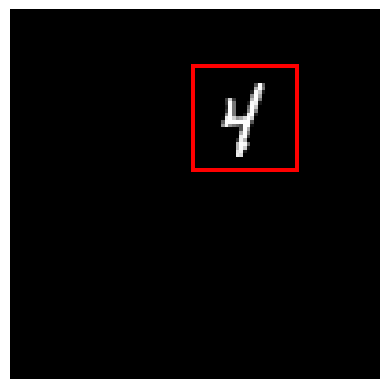

In [11]:
plot_img(train_df.iloc[0,0] ,train_df.iloc[0,2],train_df.iloc[0,3],train_df.iloc[0,4],train_df.iloc[0,5] )

In [12]:
import tensorflow as tf
@tf.function
def load_img(img_path , label) :
  image = tf.io.read_file(img_path)
  image = tf.image.decode_png(image, channels=1)
  image = tf.image.grayscale_to_rgb(image)
  return (image , label)

In [13]:
print(f'the lenght of training data is: {len(train_df)}')
print(f'the lenght of test data is: {len(test_df)}')

the lenght of training data is: 60000
the lenght of test data is: 10000


In [14]:
train_data , val_data , test_data = train_df , test_df[:5000] , test_df[5000:]

In [15]:
'''Convert our data to numpy '''
boxes = ['xmin' , 'ymin' , 'xmax' , 'ymax']
train_boxes = train_data[boxes].to_numpy()
val_boxes = val_data[boxes].to_numpy()
test_boxes = test_data[boxes].to_numpy()
train_indexes = train_data['class_index'].to_numpy()
val_indexes = val_data['class_index'].to_numpy()
test_indexes = test_data['class_index'].to_numpy()

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['path'].to_list() , {'boxes' : train_boxes , 'index' : train_indexes}))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data['path'].to_list() , {'boxes' : val_boxes , 'index' : val_indexes}))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data['path'].to_list() , {'boxes' : test_boxes , 'index' : test_indexes}))

In [17]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), {'boxes': TensorSpec(shape=(4,), dtype=tf.float64, name=None), 'index': TensorSpec(shape=(), dtype=tf.int64, name=None)})>

In [18]:
data =iter(train_dataset)

In [19]:
load_img(*next(data))[0].numpy().shape

(100, 100, 3)

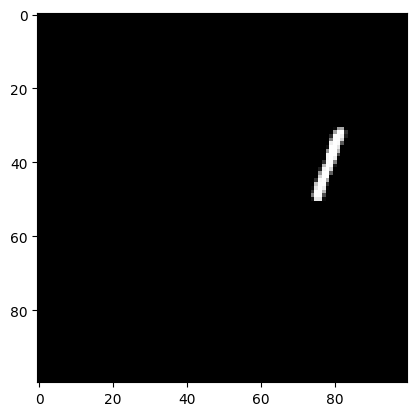

In [20]:
plt.imshow(load_img(*next(data))[0])

In [21]:
'''make our data in batches '''
from tensorflow.data import AUTOTUNE
BATCH_SIZE =128*2
shuffle_val = len(train_data)
train_data_batch = train_dataset.shuffle(shuffle_val).map(load_img).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val__data_batch = val_dataset.map(load_img).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_data_batch = test_dataset.map(load_img).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [22]:
train_data_batch

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), {'boxes': TensorSpec(shape=(None, 4), dtype=tf.float64, name=None), 'index': TensorSpec(shape=(None,), dtype=tf.int64, name=None)})>

In [23]:
for item , lebal_dict in train_data_batch :
  print(item.shape)
  break

(256, 100, 100, 3)


In [24]:
'''Build the Model '''
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
base_model = EfficientNetV2L(weights='imagenet', include_top=False)
def create_Model(base_model, input_shape=(100,100,3)):
    input = tf.keras.Input(shape=input_shape)
    x = base_model(input, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    index_layer = tf.keras.layers.Dense(10, activation='softmax', name='index')(x)
    box_layer = tf.keras.layers.Dense(4, activation='sigmoid', name='boxes')(x)
    model = tf.keras.Model(inputs=input, outputs=[index_layer, box_layer])
    return model

473176280/473176280 [==============================] - 20s 0us/step


In [25]:
for layer in base_model.layers :
  layer.trainable = False
model = create_Model(base_model=base_model)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 efficientnetv2-l (Function  (None, None, None, 1280)     1177468   ['input_2[0][0]']             
 al)                                                      48                                      
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['efficientnetv2-l[0][0]']    
 GlobalAveragePooling2D)                                                                          
                                                                                              

In [27]:
from tensorflow.keras.losses import MeanSquaredError , SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy , MeanAbsoluteError
model.compile(
    loss= {
        'index' :SparseCategoricalCrossentropy(),
        'boxes' :MeanSquaredError()
    },
    optimizer = Adam(learning_rate=0.001) ,
    metrics = {
        'index' :[CategoricalAccuracy()],
        'boxes' : [MeanAbsoluteError() ]
    }
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=1 , monitor='val_loss')


In [64]:
history = model.fit(train_data_batch ,validation_data=val__data_batch , epochs=50 , callbacks=[es])

Epoch 1/50
235/235 [==============================] - 220s 937ms/step - loss: 0.6395 - index_loss: 0.6314 - boxes_loss: 0.0081 - index_categorical_accuracy: 0.0989 - boxes_mean_absolute_error: 0.0705 - val_loss: 0.4394 - val_index_loss: 0.4349 - val_boxes_loss: 0.0045 - val_index_categorical_accuracy: 0.1086 - val_boxes_mean_absolute_error: 0.0523
Epoch 2/50
235/235 [==============================] - 220s 936ms/step - loss: 0.6281 - index_loss: 0.6201 - boxes_loss: 0.0080 - index_categorical_accuracy: 0.0980 - boxes_mean_absolute_error: 0.0702 - val_loss: 0.4273 - val_index_loss: 0.4231 - val_boxes_loss: 0.0042 - val_index_categorical_accuracy: 0.0988 - val_boxes_mean_absolute_error: 0.0503
Epoch 3/50
235/235 [==============================] - 220s 937ms/step - loss: 0.6207 - index_loss: 0.6128 - boxes_loss: 0.0080 - index_categorical_accuracy: 0.0978 - boxes_mean_absolute_error: 0.0699 - val_loss: 0.4214 - val_index_loss: 0.4171 - val_boxes_loss: 0.0043 - val_index_categorical_accurac

In [72]:
losses = pd.DataFrame(history.history)

In [73]:
losses

,loss,index_loss,boxes_loss,index_categorical_accuracy,boxes_mean_absolute_error,val_loss,val_index_loss,val_boxes_loss,val_index_categorical_accuracy,val_boxes_mean_absolute_error
0,0.639460,0.631387,0.008073,0.098917,0.070468,0.439405,0.434946,0.004459,0.1086,0.052341
1,0.628094,0.620086,0.008008,0.098033,0.070206,0.427268,0.423098,0.004171,0.0988,0.050326
2,0.620710,0.612758,0.007952,0.097750,0.069947,0.421380,0.417051,0.004329,0.0936,0.051137
3,0.610813,0.603139,0.007674,0.098483,0.068638,0.443623,0.439568,0.004056,0.0926,0.049523


Text(0.5, 1.0, 'loss and val_loss')

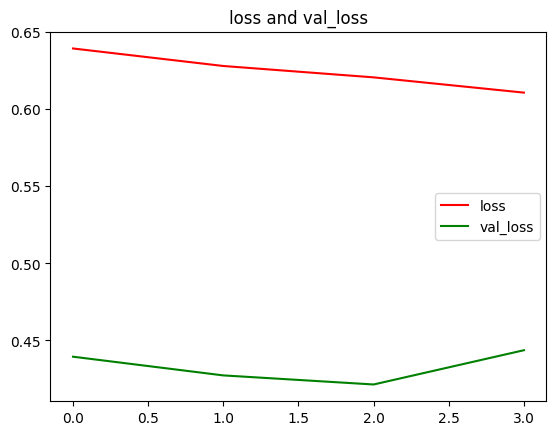

In [74]:
plt.plot(np.arange(0,4) , losses['loss'] , c='r', label='loss')
plt.plot(np.arange(0,4) , losses['val_loss'] , c='g' , label='val_loss')
plt.legend()
plt.title('loss and val_loss')

In [75]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou


In [110]:
index_predection = []
true_index = []
bbox_predection = []
true_bbox = []
for batch_img , batch_label in test_data_batch :
  i = 0
  for img in batch_img :
    image = tf.expand_dims(img , axis=0)
    index_predection.append(np.argmax(model.predict(image,verbose=0)[0][0]))
    bbox_predection.append(model.predict(image, verbose=0)[1][0])
    true_index.append(batch_label['index'][i].numpy())
    true_bbox.append(batch_label['boxes'][i].numpy())
    i = i+1


In [116]:
"""Evaluate the model """
j = 0
m = 0
for item in bbox_predection :
  if (bb_intersection_over_union(item,true_bbox[m] )>=0.6) and (true_index[m] == index_predection[m])  :
    j = j+1
  m +=1
print(f'model accuracy : {j*100/len(index_predection)}% ')

model accuracy : 86.08% 


In [148]:
def plot_images(img_path, index_batch, bbox_batch):
    fig, axes = plt.subplots(2,5, figsize=(10, 10))
    for i, path in enumerate(img_path):
        col = i // 2
        row = i % 2
        img = cv2.imread(path)
        image = cv2.rectangle(img , (int(bbox_batch[i][0]*100),int(bbox_batch[i][1]*100)) , (int(bbox_batch[i][2]*100) , int(bbox_batch[i][3]*100)) , color=(255,0,0), thickness=1)
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        axes[row, col].set_title(f"predicted label: {index_batch[i]}")
    plt.show()

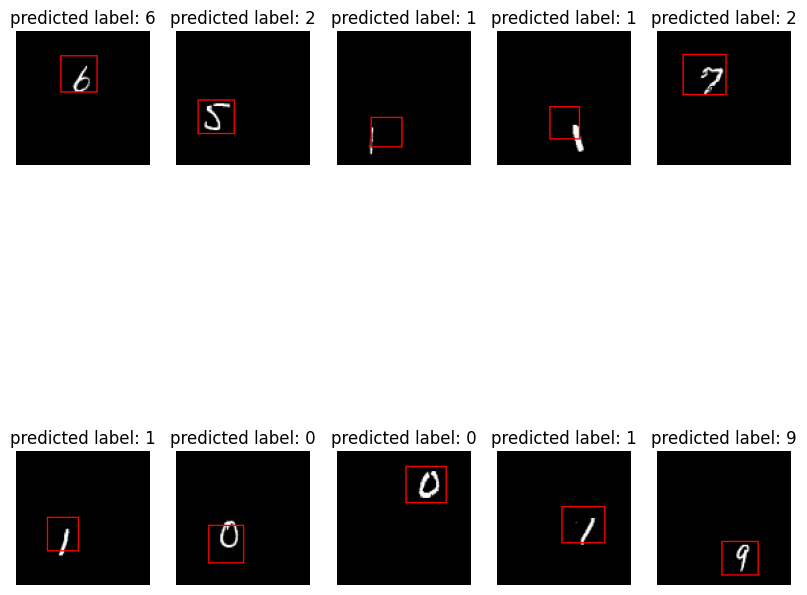

In [149]:
plot_images(test_data['path'][:10] ,index_predection[:10] , bbox_predection[:10] )